# Stereo Calibration
This notebook will provide support for stereo pair
intrinsic and extrinsic calibration.

Steps:
1. Run through the `cam002_calibration.seq` sequence.
   - You should take 10 images at difference angles with an OpenCV checkerboard calibration target. Check out [this](https://markhedleyjones.com/projects/calibration-checkerboard-collection) to get a checkerboard image to print out.
   I used a foam board with a printed paper taped to it to get a rigid calibration target.
2. Load the images from the zip file downlinked in the above sequence
   - This calibration sequence will place both the left and right frames in the same TIFF file. The TIFF format provides a lossless compression to improve calibration performance.
3. Find the checkerboard corners on all 10 frames (for both left + right)
4. Generate an intrinsic matrix for both left and right cameras
5. Rectify all frames using the intrinsic parameters
6. Use rectified frames to generate extrinsic stereo parameters for each of the 10 frames. Find the average extrinsic matrix to get the parameters.

In [13]:
import numpy as np
import cv2 as cv

from IPython.display import display
from PIL import Image

from pathlib import Path

In [14]:
print(f'numpy version: {np.__version__}')
print(f'OpenCV version: {cv.__version__}')

numpy version: 1.24.2
OpenCV version: 4.7.0


## Load Images
Point the script to the location where you `unzip`ed the TIFF files acquired from the `cam002_calibration` sequence.
Flight software will save both the left and right frames in the same image. We can extract these using the `imreadmulti`
provided by OpenCV. The `IMREAD_UNCHANGED` flag will tell OpenCV to not change the shape of the image by making them
3-channel color images.

FSW saves all these images as grayscale maps.

In [15]:
import os
IMG_LOCATION = Path(os.path.abspath(''))
image_paths = [IMG_LOCATION / f"capture{i + 1}.tiff" for i in range(10)]

LEFT = 0
RIGHT = 1

frames = [cv.imreadmulti(str(p), flags=cv.IMREAD_UNCHANGED)[1] for p in image_paths]

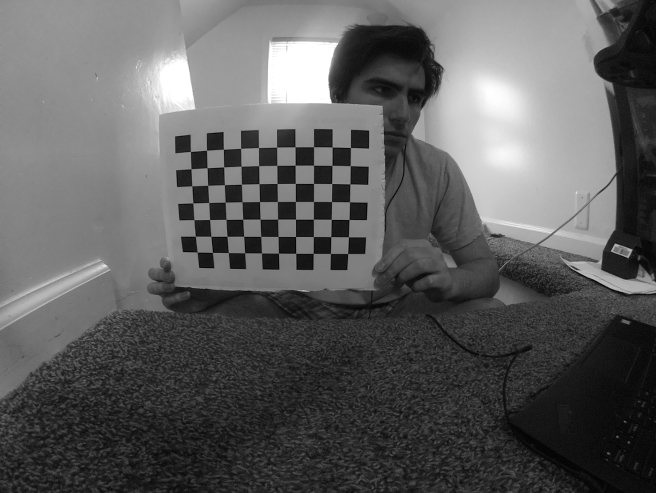

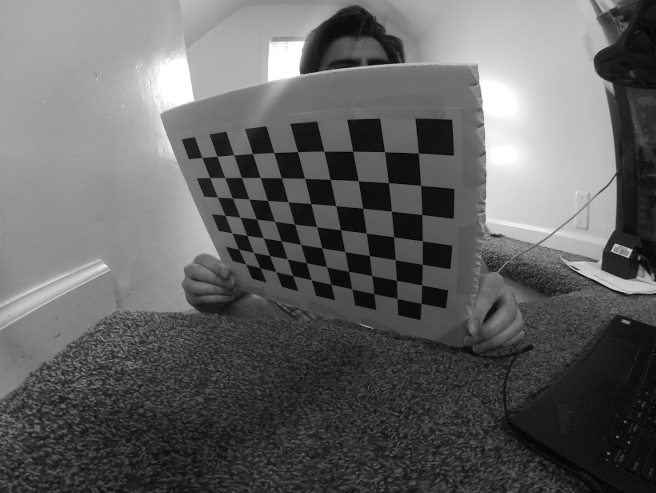

In [16]:
display(Image.fromarray(frames[9][RIGHT]))
display(Image.fromarray(frames[7][RIGHT]))

## Chessboard
Find the checkerboard corners in all the frames

`CORNER_SHAPE`: Corner matrix shape of calibration target
> Count the number of inner corners on the chessboard

`CORNER_DISTANCE`: Distance in world frame coordinate units between corners
Use the desired units in world frame. The calibration will
adjust its scaling from pixel frame to world frame coords.

> Note: You should measure accuratly with some calipers to get this just right
> We are assuming equal distances in both X-Y directions between corners.

In [17]:
CORNER_SHAPE = (10, 7)
CORNER_DISTANCE = 2.225  # cm

corners = []
for i, frame in enumerate(frames):
    left, right = frame[0], frame[1]
    left_found, left_corners = cv.findChessboardCorners(left, CORNER_SHAPE, CORNER_SHAPE)
    right_found, right_corners = cv.findChessboardCorners(right, CORNER_SHAPE, CORNER_SHAPE)

    if not left_found or not right_found:
        print(
            f"Failed to find corners on frame {i + 1}: left {'yes' if left_found else 'no'}, right {'yes' if right_found else 'no'}")
        corners.append([])
        continue

    # Refine the corner findings
    cv.cornerSubPix(left, left_corners, (11, 11), (-1, -1),
                    (cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 30, 0.01))
    cv.cornerSubPix(right, right_corners, (11, 11), (-1, -1),
                    (cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 30, 0.01))

    corners.append([left_corners, right_corners])

### Validate the Chessboard corners

Draw the corners on a selected image to make sure the corners look good

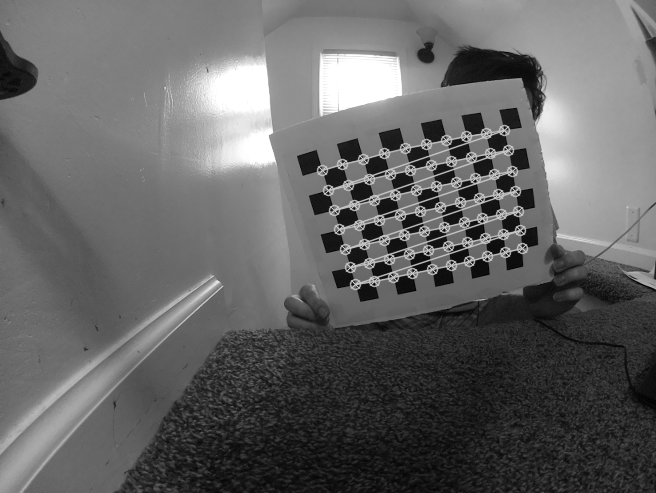

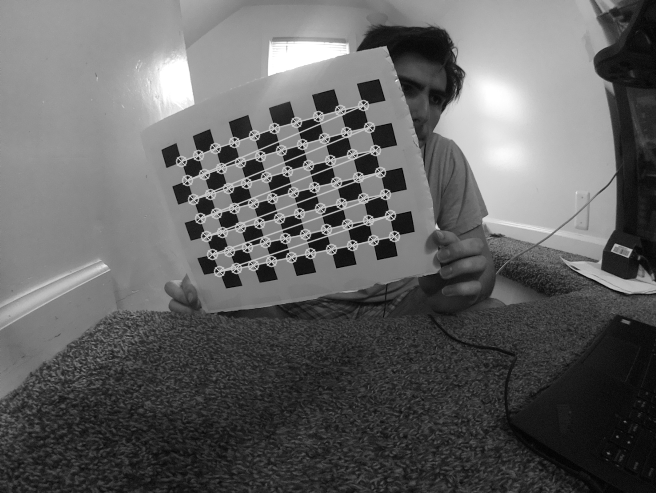

In [18]:
FRAME_TO_DISPLAY = 3
left_annotated = cv.drawChessboardCorners(frames[FRAME_TO_DISPLAY][LEFT].copy(), CORNER_SHAPE,
                                          corners[FRAME_TO_DISPLAY][LEFT], True)
right_annotated = cv.drawChessboardCorners(frames[FRAME_TO_DISPLAY][RIGHT].copy(), CORNER_SHAPE,
                                           corners[FRAME_TO_DISPLAY][RIGHT], True)

display(Image.fromarray(left_annotated))
display(Image.fromarray(right_annotated))

# Stereo Calibration

In the above steps, we manually perform the bulk of the steps required to calibrate
the stereo pair. Not all of the work is done, we still need to generate the camera
parameters using `cv.stereoCalibrate()`.

The first step is get the various camera matrices (intrinsic and extrinsic) which we will
then use generate the recitfication maps that will actually be used by flight software

In [19]:
display(frames[0][LEFT].shape)
display((frames[0][LEFT].shape[1], frames[0][LEFT].shape[0]))

(493, 656)

(656, 493)

In [20]:
corner_coordinates = np.zeros((np.prod(CORNER_SHAPE), 3), np.float32)
corner_coordinates[:, :2] = np.indices(CORNER_SHAPE).T.reshape(-1, 2)
corner_coordinates *= CORNER_DISTANCE

criteria = cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 100, 1e-5
flags = cv.CALIB_FIX_ASPECT_RATIO + cv.CALIB_ZERO_TANGENT_DIST + cv.CALIB_SAME_FOCAL_LENGTH

k_left, d_left, k_right, d_right, R, T, E, F = (
    cv.stereoCalibrate([corner_coordinates for _ in range(len(frames))],
                       [x[LEFT] for x in corners],
                       [x[RIGHT] for x in corners],
                       None, # left camera matrix
                       None, # left distortion parameters
                       None, # right camera matrix
                       None, # right distortion parameters
                       (frames[0][LEFT].shape[1], frames[0][LEFT].shape[0]),
                       criteria=criteria,
                       flags=flags)[1:]
)

In [21]:
import math
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
 
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

def eulerAnglesToRotationMatrix(theta) :
 
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])
 
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])
 
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
 
    R = np.dot(R_z, np.dot( R_y, R_x ))
 
    return R

In [22]:
display(k_left)
display(k_right)
display(d_left)
display(d_right)
display(R)
display(rotationMatrixToEulerAngles(R))
display(T)

display(frames[0][0].shape)

print(f"Calibrated Baseline: {round(abs(T[0, 0]),2)} cm")

array([[315.81992454,   0.        , 319.72591636],
       [  0.        , 315.81992454, 248.74922547],
       [  0.        ,   0.        ,   1.        ]])

array([[315.81992454,   0.        , 317.8089399 ],
       [  0.        , 315.81992454, 245.65857314],
       [  0.        ,   0.        ,   1.        ]])

array([[-0.34433178,  0.14788366,  0.        ,  0.        , -0.03315342]])

array([[-0.34975363,  0.16341871,  0.        ,  0.        , -0.03570517]])

array([[ 9.94641321e-01, -7.98118957e-04, -1.03382809e-01],
       [-2.37652572e-03,  9.99529471e-01, -3.05808492e-02],
       [ 1.03358572e-01,  3.06626682e-02,  9.94171417e-01]])

array([ 0.03083266, -0.10354349, -0.00238932])

array([[-1.18259819e+01],
       [ 1.07475747e-02],
       [-6.49754004e-01]])

(493, 656)

Calibrated Baseline: 11.83 cm


## Stereo Test

Test out the rectification and point cloud projection on the
camera set up using the calibrated parameters.

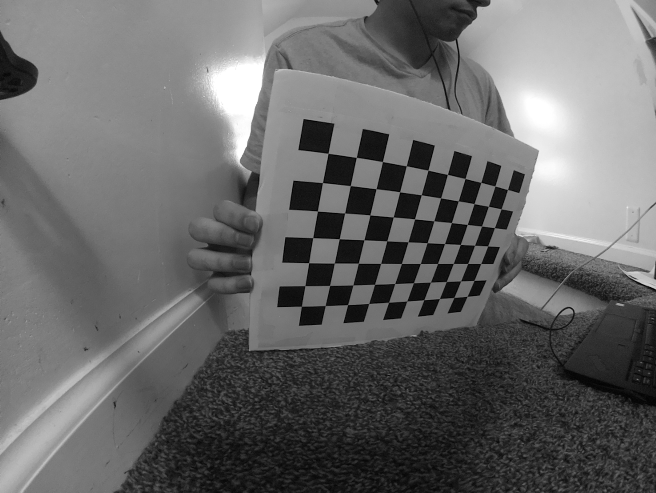

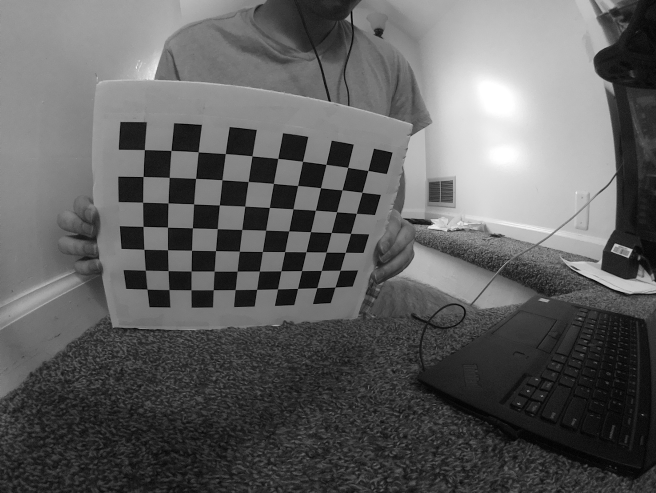

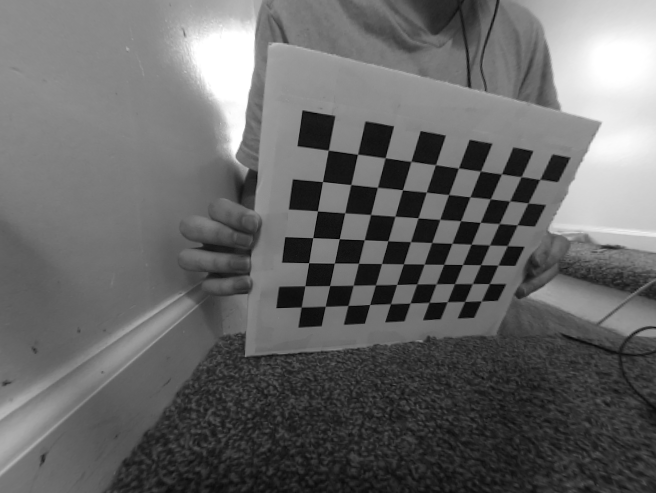

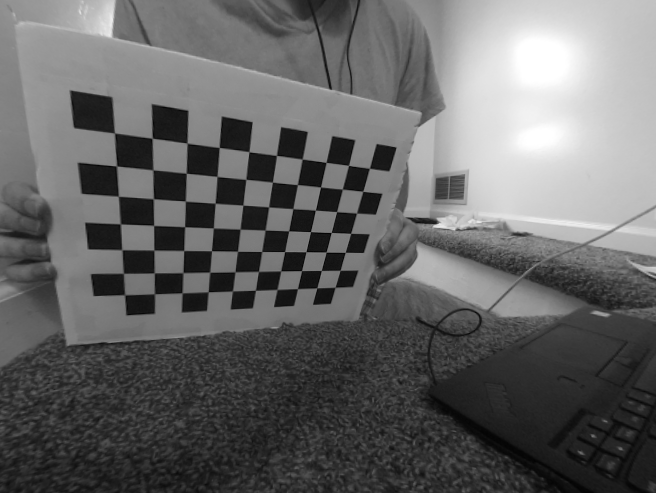

In [23]:
# Un-distort
UNDISTORT_FRAME = 8
rectified_left = cv.undistort(frames[UNDISTORT_FRAME][LEFT].copy(), k_left, d_left)
rectified_right = cv.undistort(frames[UNDISTORT_FRAME][RIGHT].copy(), k_right, d_right)

display(Image.fromarray(frames[UNDISTORT_FRAME][LEFT]))
display(Image.fromarray(frames[UNDISTORT_FRAME][RIGHT]))
display(Image.fromarray(rectified_left))
display(Image.fromarray(rectified_right))

In [24]:
stereo = cv.StereoBM()
#disparity = stereo.compute(rectified_left, rectified_right)

# Flight-software interface
Next we will create a FSW sequence that will load the camera model into the FSW calibration model
This will allow the stereo pipeline stages to work

In [25]:
import jinja2

MODEL_NUMBER = 2
template = jinja2.Template(open('vis000_model.seq.templ').read())

sequence = template.render(
    model=MODEL_NUMBER,
    k_left=k_left,
    k_right=k_right,
    d_left=d_left,
    d_right=d_right,
    R=R,
    T=T,
    R_euler=rotationMatrixToEulerAngles(R),
    width=frames[0][LEFT].shape[1],
    height=frames[0][LEFT].shape[0],
)

Write the sequence down to a file

In [26]:
sequence_path = (IMG_LOCATION.parent.parent / 'seq' / f'vis000_model-{MODEL_NUMBER}.seq')
overwrite = True
if sequence_path.exists():
    overwrite = input(f"Enter any charater to overwrite {sequence_path.name}")

if overwrite:
    print(f"Writing to {sequence_path}")
    with sequence_path.open("w+") as f:
        f.write(sequence)


Writing to /home/tumbar/git/stereo-heli/seq/vis000_model-2.seq
